In [1]:
import sys
import os

sys.path.append("..")
sys.path.append("../..")
from data.utils.pyramid_embedding_dataloader import PyramidEmbeddingDataloader
from encoders.image_encoder import BaseImageEncoderConfig
from encoders.openclip_encoder import OpenCLIPNetworkConfig, PatchDropout
from typing import (
    Dict,
    ForwardRef,
    Generic,
    List,
    Literal,
    Optional,
    Tuple,
    Type,
    Union,
    cast,
    get_args,
    get_origin,
)
from torchvision import transforms, io
import matplotlib.pyplot as plt
from utils.colormaps import apply_colormap
import torch
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2

/home/sandeepmukh/DeepUL294Proj/.deepulenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_median(probs, H, W, thresh=.4):
  grid = (probs[..., :1] > thresh).view(H, W).float()
  mid = grid.nonzero().median(dim = 0).values
  return [mid[1].item()], [mid[0].item()]

In [29]:
PatchDropout(.5, False)(embs[0][0].reshape(-1, 1024).unsqueeze(0)).shape

torch.Size([1, 224, 1024])

In [ ]:
image = io.read_video('/home/sandeepmukh/DeepUL294Proj/DUL294P/data/IMG_5338.MOV')[0][0].permute(2,0,1)
print(image.shape)
embs = clip_interpolator.generate_clip_interp(image.float() / 255.0)
plt.imshow(
    image_encoder.get_relevancy(embs[0][0].reshape(-1, 1024), 0)[..., 0]
      .reshape(embs[0][0].shape[:2])
      .cpu()
      .numpy(),
      interpolation="bicubic",
)
plt.show()
plt.imshow(image.cpu().permute(1, 2, 0).numpy())
get_median(image_encoder.get_relevancy(embs[0][0].reshape(-1, 1024), 0), *embs[0][0].shape[:2])

In [4]:
device = "cuda:4"
"""The device to run on"""
patch_tile_size_range: Tuple[int, int] = (0.08, 0.5)
"""The range of tile sizes to sample from for patch-based training"""
patch_tile_size_res: int = 2
"""The number of tile sizes to sample from for patch-based training"""
patch_stride_scaler: float = .5
"""The stride scaler for patch-based training"""
network: BaseImageEncoderConfig = OpenCLIPNetworkConfig(
    device=device, clip_n_dims=1024, clip_model_type="ViT-H-14", clip_model_pretrained='laion2b_s32b_b79k'
    )
network.output_tokens = False

"""specifies the vision-language network config"""
clip_downscale_factor: int = 1
"""The downscale factor for the clip pyramid"""

clip_interpolator = PyramidEmbeddingDataloader(
    device=device,
    cfg={
        "tile_size_range": list(patch_tile_size_range),
        "tile_size_res": patch_tile_size_res,
        "stride_scaler": patch_stride_scaler,
        # "image_shape": [h,w],
    },
    model=network.setup(),
)
# clip_interpolator.embed_size = 512
image_encoder = clip_interpolator.model
# image_encoder.model.visual.load_state_dict(
#     torch.load("/home/sandeepmukh/DeepUL294Proj/DUL294P/checkpoints/model.pth")
# )
image_encoder.model.visual.patch_dropout = PatchDropout(.75)

imgs = []
centers = []
for idx, image in enumerate(io.read_video('/home/sandeepmukh/DeepUL294Proj/DUL294P/data/IMG_5338.MOV')[0][::10]):
    transform = transforms.Compose([transforms.Resize((250, 400))])
    # ### Load human readable labels dictionary from data/labels/imagenet1k_labels.txt
    # labels = 'person wearing a red and black'
    labels = 'Young man in red jacket.'
    # labels = 'office door'
    # # import pdb; pdb.set_trace()

    data = {}
    image = image.permute(2,0,1)
    print(image.shape)
    clip_interpolator.generate_clip_interp(image.float() / 255.0)
    H, W = image.shape[1:]

    scale = torch.tensor(0.1).to(device)
    scaled_height = H // clip_downscale_factor
    scaled_width = W // clip_downscale_factor
    # random_pixels = torch.randperm(scaled_height*scaled_width)[:int((scaled_height*scaled_height)*0.5)]

    x = (
        torch.arange(0, scaled_width * clip_downscale_factor, clip_downscale_factor)
        .view(1, scaled_width, 1)
        .expand(scaled_height, scaled_width, 1)
        .to(device)
    )
    y = (
        torch.arange(
            0, scaled_height * clip_downscale_factor, clip_downscale_factor
        )
        .view(scaled_height, 1, 1)
        .expand(scaled_height, scaled_width, 1)
        .to(device)
    )
    image_idx_tensor = torch.zeros(scaled_height, scaled_width, 1).to(device)
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    # positions = positions[random_pixels]
    with torch.no_grad():
        # data["clip"], data["clip_scale"] = clip_interpolator(positions, scale)[0], clip_interpolator(positions, scale)[1]
        data["clip"] = clip_interpolator(positions)[0]

    # import pdb; pdb.set_trace()

    positive = labels
    # import pdb; pdb.set_trace()
    image_encoder.set_positives(positive)
    probs = image_encoder.get_relevancy(
        data["clip"].view(-1, image_encoder.embedding_dim), 0
    )
    cutoff = probs[..., :1].float().quantile(.8)
    color = apply_colormap(probs[..., 0:1])
    color = color.reshape([H, W, 3])
    # Show image and heatmap side by side
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.permute(1, 2, 0))
    ax[1].imshow(color.cpu().numpy())
    ax[0].scatter(*get_median(probs, H, W, cutoff), c='g')
    ax[1].scatter(*get_median(probs, H, W, cutoff), c='g')
    fig.suptitle(positive)
    plt.show()
    imgs.append(image)
    centers.append(get_median(probs, H, W, cutoff))
    # break
# plt.show(f"test_clip_interp_{i}_{positive}.png")

torch.Size([3, 1080, 1920])


Scales:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([405, 3, 86, 86])


Scales: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

torch.Size([40, 3, 540, 540])
PyramidEmbeddingProcess took 0.6834659576416016 seconds


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.96 GiB. GPU 4 has a total capacity of 79.15 GiB of which 1.68 GiB is free. Process 3366735 has 58.40 GiB memory in use. Process 3746334 has 4.26 GiB memory in use. Including non-PyTorch memory, this process has 14.78 GiB memory in use. Of the allocated memory 14.01 GiB is allocated by PyTorch, and 270.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

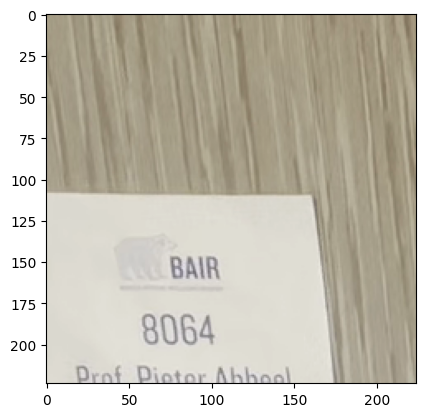

In [4]:
x = transforms.Resize((1080, 1920))(imgs[8])

def chunk_img(x):
  kc, kh, kw = 3, 224, 224  # kernel size
  dc, dh, dw = 3, 224, 224  # stride
  # Pad to multiples of 32
  x = F.pad(x, (x.size(2)%kw // 2, x.size(2)%kw // 2,
                x.size(1)%kh // 2, x.size(1)%kh // 2,
                x.size(0)%kc // 2, x.size(0)%kc // 2), mode='replicate')

  patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
  unfold_shape = patches.size()
  patches = patches.contiguous().view(-1, kc, kh, kw)
  return patches, unfold_shape

def unchunk_img(patches, unfold_shape):
  patches_orig = patches.view(unfold_shape)
  output_c = unfold_shape[1] * unfold_shape[4]
  output_h = unfold_shape[2] * unfold_shape[5]
  output_w = unfold_shape[3] * unfold_shape[6]
  patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
  patches_orig = patches_orig.view(1, output_c, output_h, output_w)
  return patches_orig

patches = chunk_img(x.unsqueeze(0))[0]
image_encoder.set_positives('red jacket')

encs = image_encoder.encode_image(image_encoder.process(patches.float()).to(device))

probs = image_encoder.get_relevancy(encs, 0)
plt.imshow(patches[probs[..., 0:1].argmax()].squeeze().permute(1, 2, 0).cpu().numpy())

100%|██████████| 24/24 [00:00<00:00, 94.21it/s] 


KeyboardInterrupt: 

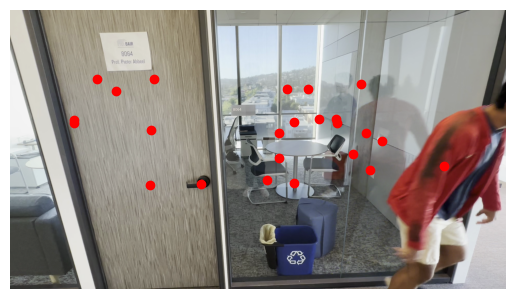

In [5]:
# put images together as a video and plot the centers on each image

# imgs = torch.stack(imgs)
# centers = torch.tensor(centers)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

frames = [] # for storing the generated images
fig = plt.figure()
plt.axis('off')
for i in tqdm(range(len(imgs))):
    frames.append([plt.imshow(imgs[i].permute(1,2,0), animated=True), plt.scatter(*centers[i], c='r',)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
writergif = animation.PillowWriter(fps=10)
ani.save('movie.gif', writer=writergif)
plt.show()